In [1]:
import PIL.Image as pilimg
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import json
import cv2
import os

### - Install & using COCO API

In [2]:
!pip install pycocotools

In [3]:
from pycocotools.coco import COCO

In [4]:
 # Load COCO dataset - Create COCO object then load images and annotations
root_path = '/home/taeyongkong/sdb1/Data/Detection/set_origin/coco2017_data_set_origin'
label_folder = 'annotations_trainval2017'
data_version = 'train2017'

annotation_path = os.path.join(
            root_path, label_folder, 'annotations', 'person_keypoints_%s.json' % data_version
        )

print('COCO annotation path:', annotation_path)

coco = COCO(annotation_path)

COCO annotation path: /home/taeyongkong/sdb1/Data/Detection/set_origin/coco2017_data_set_origin/annotations_trainval2017/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=5.36s)
creating index...
index created!


In [5]:
# Params
nof_joints = 17
nof_joints_half_body = 8
image_width = 288
image_height = 384
aspect_ratio = image_width * 1.0 / image_height
pixel_std = 200

In [6]:
# x/y/w/h -> center, scale
def xywh2cs(box):
    x, y, w, h = box
    center = np.zeros((2,), dtype=np.float32)
    center[0] = x + w * 0.5
    center[1] = y + h * 0.5

    if w > aspect_ratio * h:
        h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio
    scale = np.array(
        [w * 1.0 / pixel_std, h * 1.0 / pixel_std],
        dtype=np.float32)
    if center[0] != -1:
        scale = scale * 1.25

    return center, scale

In [7]:
# Build data list
imgIds = coco.getImgIds()
data = []

for i, imgId in enumerate(imgIds):
            
    # e.g. {'license': 3, 'file_name': '000000056865.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000056865.jpg',
    # 'height': 427, 'width': 640, 'date_captured': '2013-11-18 08:22:21',
    # 'flickr_url': 'http://farm8.staticflickr.com/7327/8730548852_12413ff6d6_z.jpg', 'id': 56865}
    img = coco.loadImgs(imgId)[0]
    
    # e.g. [202758, 1260346]
    ann_ids = coco.getAnnIds(imgIds=imgId, iscrowd=False)
    
    # [{'segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'}, ...]
    objs = coco.loadAnns(ann_ids)
    
    # sanitize bboxes
    valid_objs = []
    for obj in objs:
        # Skip non-person objects (it should never happen)
        if obj['category_id'] != 1:
            continue

        # Ignore objs without keypoints annotation
        if max(obj['keypoints']) == 0:
            continue

        x, y, w, h = obj['bbox']
        x1 = np.max((0, x))
        y1 = np.max((0, y))
        x2 = np.min((img['width'] - 1, x1 + np.max((0, w - 1))))
        y2 = np.min((img['height'] - 1, y1 + np.max((0, h - 1))))

        # Use only valid bounding boxes
        if obj['area'] > 0 and x2 >= x1 and y2 >= y1:
            obj['clean_bbox'] = [x1, y1, x2 - x1, y2 - y1]
            valid_objs.append(obj)

    objs = valid_objs
                
    for a, obj in enumerate(objs):
        joints = np.zeros((nof_joints, 2), dtype=np.float)
        joints_visibility = np.ones((nof_joints, 2), dtype=np.float)
        
        for pt in range(nof_joints):
            joints[pt, 0] = obj['keypoints'][pt * 3 + 0]
            joints[pt, 1] = obj['keypoints'][pt * 3 + 1]
            t_vis = int(np.clip(obj['keypoints'][pt * 3 + 2], 0, 1))  # ToDo check correctness
            
            # COCO:
            # v=0: not labeled (in which case x=y=0), v=1: labeled but not visible, v=2: labeled and visible
            #   if visibility == 0 -> keypoint is not in the image.
            #   if visibility == 1 -> keypoint is in the image BUT not visible (e.g. behind an object).
            #   if visibility == 2 -> keypoint looks clearly (i.e. it is not hidden).
            
            joints_visibility[pt, 0] = t_vis
            joints_visibility[pt, 1] = t_vis
        
        center, scale = xywh2cs(obj['bbox'][:4])
        
        data.append({
                    'imgId': imgId,
                    'annId': obj['id'],
                    'imgPath': os.path.join(root_path, data_version, '%012d.jpg' % imgId),
                    'center': center,
                    'scale': scale,
                    'joints': joints,
                    'joints_visibility': joints_visibility,
                })
        
print('len of data:', len(data))
print(data[0])

/tmp/ipykernel_3570761/305612777.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  joints = np.zeros((nof_joints, 2), dtype=np.float)
/tmp/ipykernel_3570761/305612777.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  joints_visibility = np.ones((nof_joints, 2), dtype=np.float)


len of data: 149813
{'imgId': 391895, 'annId': 202758, 'imgPath': '/home/taeyongkong/sdb1/Data/Detection/set_origin/coco2017_data_set_origin/train2017/000000391895.jpg', 'center': array([416.82 , 172.525], dtype=float32), 'scale': array([1.4096719, 1.8795624], dtype=float32), 'joints': array([[368.,  61.],
       [369.,  52.],
       [  0.,   0.],
       [382.,  48.],
       [  0.,   0.],
       [368.,  84.],
       [435.,  81.],
       [362., 125.],
       [446., 125.],
       [360., 153.],
       [  0.,   0.],
       [397., 167.],
       [439., 166.],
       [369., 193.],
       [461., 234.],
       [361., 246.],
       [474., 287.]]), 'joints_visibility': array([[1., 1.],
       [1., 1.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])}


### - Show image & label (COCO)

size of img: (360, 640, 3)
img: [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[164 140 140]
  [131  83  63]
  [172 152  83]
  ...
  [ 55  62  20]
  [ 55  59  26]
  [ 40  39   8]]

 [[201 164 138]
  [142 107  79]
  [150 117  98]
  ...
  [ 72  88  41]
  [ 73  86  33]
  [ 66 100  13]]

 [[176 157 125]
  [201 181 128]
  [188 165 124]
  ...
  [ 47  57  33]
  [ 55  72  27]
  [ 60  79  24]]]


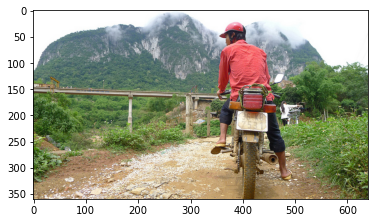

In [8]:
img_path = data[0]['imgPath']

# Read image
img = cv2.imread(img_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = img.resize((image_width, image_height))
img = np.array(img)

# Show test image
print('size of img:', img.shape)
print('img:', img)
imshow(img)

In [9]:
keypoints = data[0]['joints']
    
# Show label
# (x, y, v) format
print('Keypoints:', keypoints)

# Convert to inferencing format (y, x, confidence)
# Shape = (people_num, key_points_num, 2)
keypoints_np = np.zeros((1, 18, 3))
for i, keypoint in enumerate(keypoints[:, :2]):
    if keypoint[0] == 0 and keypoint[1] == 0:
        conf = 0
    else:
        conf = 1
    keypoints_np[0][i] = [keypoint[1], keypoint[0], conf]
    
keypoints = np.expand_dims(np.insert(keypoints, 2, 1, axis=1), 0)
print('Keypoints numpy:', keypoints_np, keypoints_np.shape)

Keypoints: [[368.  61.]
 [369.  52.]
 [  0.   0.]
 [382.  48.]
 [  0.   0.]
 [368.  84.]
 [435.  81.]
 [362. 125.]
 [446. 125.]
 [360. 153.]
 [  0.   0.]
 [397. 167.]
 [439. 166.]
 [369. 193.]
 [461. 234.]
 [361. 246.]
 [474. 287.]]
Keypoints numpy: [[[ 61. 368.   1.]
  [ 52. 369.   1.]
  [  0.   0.   0.]
  [ 48. 382.   1.]
  [  0.   0.   0.]
  [ 84. 368.   1.]
  [ 81. 435.   1.]
  [125. 362.   1.]
  [125. 446.   1.]
  [153. 360.   1.]
  [  0.   0.   0.]
  [167. 397.   1.]
  [166. 439.   1.]
  [193. 369.   1.]
  [234. 461.   1.]
  [246. 361.   1.]
  [287. 474.   1.]
  [  0.   0.   0.]]] (1, 18, 3)


### - Define skeleton

In [10]:
joints = {
    "pose_estimation_coco": {
        "keypoints": {
            0: "nose",
            1: "left_eye",
            2: "right_eye",
            3: "left_ear",
            4: "right_ear",
            5: "left_shoulder",
            6: "right_shoulder",
            7: "left_elbow",
            8: "right_elbow",
            9: "left_wrist",
            10: "right_wrist",
            11: "left_hip",
            12: "right_hip",
            13: "left_knee",
            14: "right_knee",
            15: "left_ankle",
            16: "right_ankle"
        },
        "skeletons": [
            [15, 13], [13, 11], [16, 14], [14, 12], [11, 12], [5, 11], [6, 12], [5, 6], 
            [5, 7], [6, 8], [7, 9], [8, 10], [1, 2], [0, 1], [0, 2], [1, 3], 
            [2, 4], [0, 5], [0, 6]
        ]
    }
} 

### - Draw points and skeleton

In [11]:
# Param
skeleton_color_palette = 'Set2'
points_thr = 0.5

In [12]:
# Draw points and skeleton of people
def draw_points_and_skeleton(frame, points_list, pid_list, pose_estimation_joints, skeleton_color_palette, points_thr):

    for i, (points, pid) in enumerate(zip(points_list, pid_list)):
        frame = draw_skeleton(frame, points, pid, pose_estimation_joints, skeleton_color_palette)
        frame = draw_points(frame, points, skeleton_color_palette)

    return frame


def draw_skeleton(frame, points, pid, pose_estimation_joints, skeleton_color_palette):

    try:
        colors = np.round(
            np.array(plt.get_cmap(skeleton_color_palette).colors) * 255
        ).astype(np.uint8)[:, ::-1].tolist()
    except AttributeError:  # if palette has not pre-defined colors
        colors = np.round(
            np.array(plt.get_cmap(skeleton_color_palette)(np.linspace(0, 1, palette_samples))) * 255
        ).astype(np.uint8)[:, -2::-1].tolist()

    for i, joint in enumerate(pose_estimation_joints):
        pt1 = points[joint[0]]
        pt2 = points[joint[1]]
        
        if pt1[2] > points_thr and pt2[2] > points_thr:
            frame = cv2.line(
                frame, (int(pt1[1]), int(pt1[0])), (int(pt2[1]), int(pt2[0])),
                tuple(colors[pid % len(colors)]), 2
            )

    return frame


def draw_points(frame, points, skeleton_color_palette):
    
    try:
        colors = np.round(
            np.array(plt.get_cmap(skeleton_color_palette).colors) * 255
        ).astype(np.uint8)[:, ::-1].tolist()
    except AttributeError:  # if palette has not pre-defined colors
        colors = np.round(
            # np.array(plt.get_cmap(skeleton_color_palette)(np.linspace(0, 1, 17))) * 255
            np.array(plt.get_cmap(skeleton_color_palette)(np.linspace(0, 1, palette_samples))) * 255
        ).astype(np.uint8)[:, -2::-1].tolist()

    circle_size = max(1, min(frame.shape[:2]) // 160)  # ToDo Shape it taking into account the size of the detection
    # circle_size = max(2, int(np.sqrt(np.max(np.max(points, axis=0) - np.min(points, axis=0)) // 16)))

    for i, pt in enumerate(points):
        if pt[2] > points_thr:
            frame = cv2.circle(frame, (int(pt[1]), int(pt[0])), circle_size, tuple(colors[i % len(colors)]), -1)

    return frame

In [13]:
result_frame = draw_points_and_skeleton(frame=img, points_list=keypoints_np, pid_list=[1], \
                         pose_estimation_joints=joints['pose_estimation_coco']['skeletons'],
                         skeleton_color_palette=skeleton_color_palette, \
                         points_thr=points_thr)

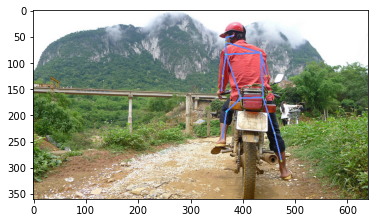

In [14]:
imshow(result_frame)